In [34]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import openml
from scipy.stats import wilcoxon
import os
import json

image_folder = "./resultImages"

In [35]:
df = []
dir_name = 'res2'

for file in os.listdir(dir_name):
    with open(os.path.join(dir_name, file), 'r') as f:
        df.append(json.load(f))

df = pd.DataFrame(df)
print(df.shape)
df.head()
df.to_csv("res4.csv")

(134, 7)


In [36]:
# Some functions for the processing of the csv

def parse_results(string):
    
    def find_nth(string, n):
        first = string.find("[", n)
        last = string.find("]", n + 1)
        return string[first:last+1], last
    index = 0
    parsed = {}

    res, index = find_nth(string, index)
    parsed["fit_time"] = ast.literal_eval(res)

    res, index = find_nth(string, index)
    parsed["score_time"] = ast.literal_eval(res)

    res, index = find_nth(string, index)
    parsed["test_accuracy"] = ast.literal_eval(res)

    res, index = find_nth(string, index)

    parsed["test_precision_weighted"] = ast.literal_eval(res)

    res, index = find_nth(string, index)
    parsed["test_recall_weighted"] = ast.literal_eval(res)

    res, index = find_nth(string, index)
    parsed["test_f1_weighted"] = ast.literal_eval(res)

    res, index = find_nth(string, index)
    parsed["test_roc_auc_ovr_weighted"] = ast.literal_eval(res)

    return parsed

def mean_results(dc):
    return np.mean(dc["test_f1_weighted"])

def data_properties(id, features=True):
    dataset = openml.datasets.get_dataset(id)
    if features:
        return len(dataset.features)
    else:
        data = dataset.get_data()
        return len(data[0])

# Statistical test
def statistical_performance(row, time=False):
    alpha = 0.05
    no_feature_selection = row.cv_before["test_f1_weighted"]
    feature_selection = row.cv_after["test_f1_weighted"]
    if time:
        no_feature_selection =  np.add(row.cv_before["fit_time"], row.cv_before["score_time"])
        feature_selection =  np.add(row.cv_after["fit_time"], row.cv_after["score_time"])

    # if no_feature_selection == feature_selection:
    #     return False
    w, p = wilcoxon(no_feature_selection, feature_selection, zero_method="zsplit")
    if p > alpha:
        return False
    else:
        return True


In [37]:
# Process dataframe for right values

results = pd.read_csv("res_df.csv", index_col=False)
results2 = pd.read_csv("res3.csv", index_col=False)
results = pd.concat([results, results2])

results = results[results.model != "SVC"] # Contains NaN
print(results["model"].value_counts())
results["cv_before"] = results.apply(lambda row : parse_results(row["cv_before"]), axis=1)
results["cv_after"] = results.apply(lambda row : parse_results(row["cv_after"]), axis=1)

results["f1_before"] = results.apply(lambda row : mean_results(row["cv_before"]), axis=1)
results["f1_after"] = results.apply(lambda row : mean_results(row["cv_after"]), axis=1)

results["num_features"] = results.apply(lambda row : data_properties(row["ID"]), axis=1)
results["num_datapoints"] = results.apply(lambda row : data_properties(row["ID"], features=False), axis=1)

results["feature_better_f1"] = results.apply(lambda row : (True if row["f1_before"] < row["f1_after"] else False), axis=1)
results["feature_better_time"] = results.apply(lambda row : (True if row["regular_time"] > row["featured_time"] else False), axis=1)

results["stat_performance"] = results.apply(lambda row : statistical_performance(row), axis=1)
results["stat_time"] = results.apply(lambda row : statistical_performance(row, time=True), axis=1)

# Create seperate df for each algorithm
gradient = results[results.model == "GradientBoostingClassifier"]
knn = results[results.model == "KNeighborsClassifier"]
Dtree = results[results.model == "DecisionTreeClassifier"]
LogReg = results[results.model == "LogisticRegression"]
RF = results[results.model == "RandomForestClassifier"]

GradientBoostingClassifier    59
KNeighborsClassifier          45
DecisionTreeClassifier        37
LogisticRegression            35
RandomForestClassifier        33
Name: model, dtype: int64


/home/koen-sub/miniconda3/envs/uni/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [38]:
# Get average performances of each algorithm

def getMeans(algSet):
    f1_before = np.mean(algSet["f1_before"])
    f1_after = np.mean(algSet["f1_after"])
    time_before = np.mean(algSet["regular_time"])
    time_after = np.mean(algSet["featured_time"])
    return [f1_before, f1_after, time_before, time_after]

gradient_means = getMeans(gradient)
knn_means = getMeans(knn)
Dtree_means = getMeans(Dtree)
LogReg_means = getMeans(LogReg)
RF_means = getMeans(RF)

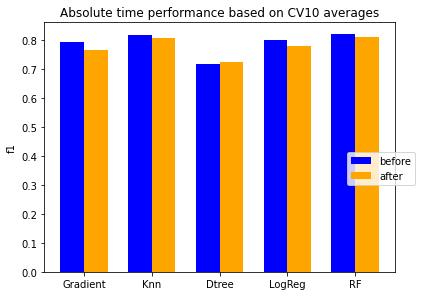

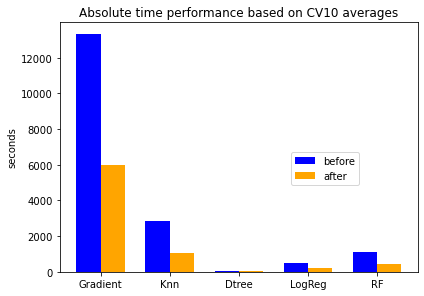

In [39]:
def plot_before_after(before, after, ylabel):
    labels = ["Gradient", "Knn", "Dtree", "LogReg", "RF"]
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, before, width, label='before', color="blue")
    rects2 = ax.bar(x + width/2, after, width, label='after', color="orange")
    
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(0.85,0.5))
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    fig.tight_layout()
    plt.title("Absolute time performance based on CV10 averages")
    plt.savefig(image_folder + "/absolute_" + ylabel + ".png")
    plt.show()

plot_before_after([gradient_means[0], knn_means[0], Dtree_means[0], LogReg_means[0], RF_means[0]], 
                    [gradient_means[1], knn_means[1], Dtree_means[1], LogReg_means[1], RF_means[1]], "f1")

plot_before_after([gradient_means[2], knn_means[2], Dtree_means[2], LogReg_means[2], RF_means[2]], 
                    [gradient_means[3], knn_means[3], Dtree_means[3], LogReg_means[3], RF_means[3]], "seconds")

In [40]:
# Retrieving values for the statistical tests of each algorithm
# Better = feature selection is better
# Worse = feature selection is not better
# Neutral = no statistical difference

def getBetterWorseNeutral(algSet):
    better = algSet[(algSet.feature_better_f1 == True) & (algSet.stat_performance == True)]
    worse = algSet[(algSet.feature_better_f1 == False) & (algSet.stat_performance == True)]
    neutral = algSet[algSet.stat_performance == False]

    better_time = algSet[(algSet.feature_better_time == True) & (algSet.stat_time == True)]
    worse_time = algSet[(algSet.feature_better_time == False) & (algSet.stat_time == True)]
    neutral_time = algSet[algSet.stat_time == False]
    return (better, worse, neutral, better_time, worse_time, neutral_time)


gradient_scores = getBetterWorseNeutral(gradient)
knn_scores = getBetterWorseNeutral(knn)
Dtree_scores = getBetterWorseNeutral(Dtree)
LogReg_scores = getBetterWorseNeutral(LogReg)
RF_scores = getBetterWorseNeutral(RF)

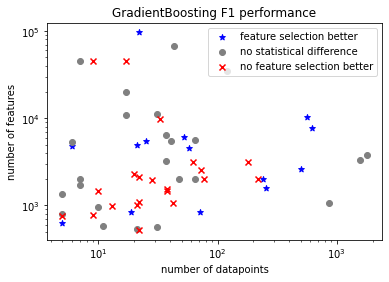

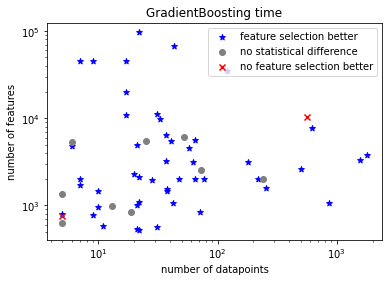

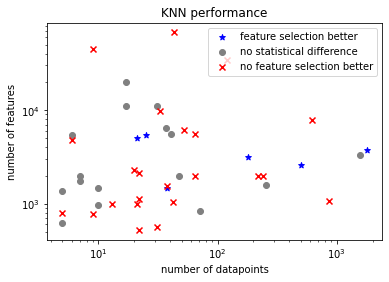

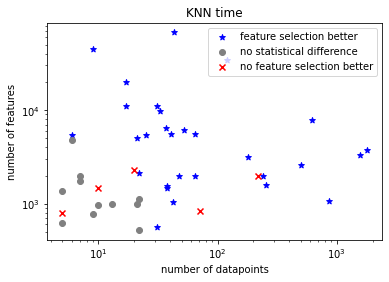

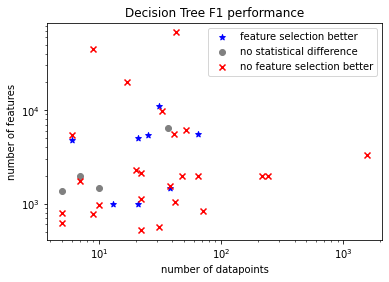

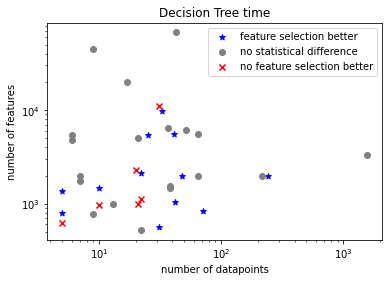

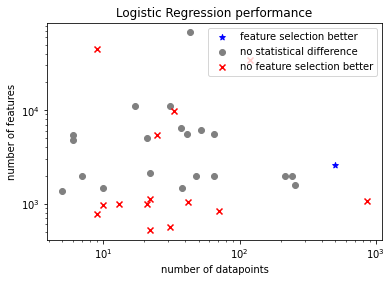

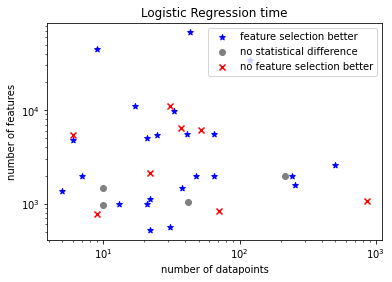

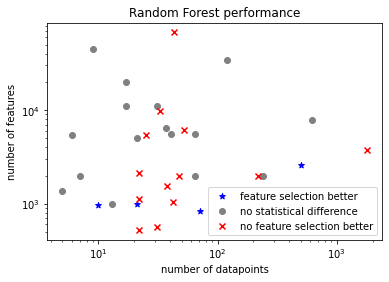

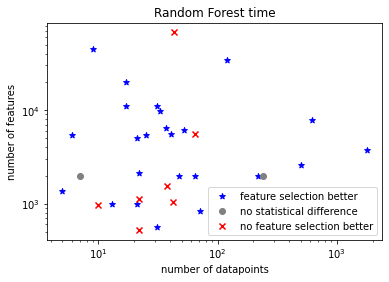

In [42]:
# Plotting

def plot_better(better, worse, neutral, title=""):
    plt.scatter(better["num_features"], better["num_datapoints"], color="blue", marker="*", label="feature selection better")
    plt.scatter(worse["num_features"], worse["num_datapoints"], color="gray", label="no statistical difference")
    plt.scatter(neutral["num_features"], neutral["num_datapoints"], color="red", marker="x", label="no feature selection better")
    
    plt.xlabel("number of datapoints")
    plt.ylabel("number of features")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.savefig(image_folder + "/statistical" + title + ".pdf")
    plt.show()

plot_better(gradient_scores[0], gradient_scores[1], gradient_scores[2], "GradientBoosting F1 performance")
plot_better(gradient_scores[3], gradient_scores[4], gradient_scores[5], "GradientBoosting time")

plot_better(knn_scores[0], knn_scores[1], knn_scores[2], "KNN performance")
plot_better(knn_scores[3], knn_scores[4], knn_scores[5], "KNN time")

plot_better(Dtree_scores[0], Dtree_scores[1], Dtree_scores[2], "Decision Tree F1 performance")
plot_better(Dtree_scores[3], Dtree_scores[4], Dtree_scores[5], "Decision Tree time")

plot_better(LogReg_scores[0], LogReg_scores[1], LogReg_scores[2], "Logistic Regression performance")
plot_better(LogReg_scores[3], LogReg_scores[4], LogReg_scores[5], "Logistic Regression time")

plot_better(RF_scores[0], RF_scores[1], RF_scores[2], "Random Forest performance")
plot_better(RF_scores[3], RF_scores[4], RF_scores[5], "Random Forest time")
